##**09-2 순환 신경망으로 IMDB 리뷰 분류하기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* IMDB(Internet Movie Database)란? [Wikipedia](https://en.wikipedia.org/wiki/IMDb) 기사를 보자

* IMDB  영화리뷰 데이터 : imdb.com에서 수집한 영화 리뷰 데이터. 긍정, 부정 리뷰 각각 2만5천개씩 총 5만 개 샘플로 이루어진 데이터.

* **자연어처리와 말뭉치** : 교재 501쪽 '여기서 잠깐'에 있는 설명을 보자.

* **토큰** : 영화 리뷰 텍스트는 무엇으로 이루어져있을까? 당연히 단어들로 이루어져 있다. 이런 단어를 '토큰(token)'이라고 부르며 <u>토큰(단어) 하나가 하나의 타임스텝이 된다</u>. 즉 하나의 리뷰는 여러 단어(토큰, 타임스텝)으로 이루어진다.

  그런데 컴퓨터가 영화리뷰 텍스트 자체를 받아들여 처리할까? 아니다. 텍스트에 있는 모든 단어를 숫자로 바꿔서 처리한다.

* 어휘사전 : <u>훈련 데이터세트에 있는 고유한 단어들을 모두 모아서 만든 목록</u>을 어휘 사전이라고 부른다. 훈련 데이터세트에 없던 단어가 테스트 데이터세트에 나올 수 있는데 그런 단어는 2로 나타낸다.

**만일 코랩에서 "사용가능한 RAM을 모두 사용하여 세션이 다운"되었다고 나오면 자신의 컴퓨터에 설치된 Jupyter Notebook을 이용해서 실습할 수 있다. 이 경우 먼저 아래와 같이 tensorflow를 설치하면 된다.**

### 1) IMDB 리뷰 데이터셋

IMDB 데이터세트는 아래와 같이 불러 쓸 수 있다. `tensorflow.keras.datasets`에 있는 `imdb`에서는 영문 단어가 아니라 단어를 숫자로 바꾼 데이터를 이용할 수 있다.

In [ ]:
from tensorflow.keras.datasets import imdb

(train,target1),(test,target2)=imdb.load_data(num_words=500)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


shape을 확인해보면 `train_input, test_input` 둘 다 25,000개 값으로 이루어진 1차원 배열임을 알 수 있다.

In [ ]:
print(train.shape,test.shape)

(25000,) (25000,)


각 배열은 어떤 항목들로 이루어져 있을까? `train_input`의 첫번째 항목을 살펴보자.

In [ ]:
print(train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [ ]:
len(train[0])

121

In [ ]:
type(train[0])

list

In [ ]:
target1[0]

1

`train_input`의 첫번째 리뷰는 218개 단어로 이루어져 있고 긍정(1)적인 리뷰다.

만약 `load_data()`로 데이터를 부를 때 다음과 같이 `num_words = `을 생략한다면?

`load_data()`로 데이터를 부를 때 `num_words = `을 지정하지 않으면 모든 고유한 단어를 목록으로 만든다. `num_words = 500`으로 지정하면 사용 빈도가 높은 단어 500개만 골라서 목록으로 만든다. 500개에 포함되지 않는 단어는 2값을 갖게 된다. 따라서 `train_input2[0]`에는 2로 표현된 단어가 하나도 없지만 `train_input[0]`에서는 218개 단어 가운데 40개가 2로 표현되었다.

우리는 500개 토큰만 있는 목록을 이용한다. 먼저 리뷰마다 길이가 같은지 알아보자.

In [ ]:
len(train[1])

189

In [ ]:
target1[1]

0

`train_input[1]`은 길이가 189이고 부정적인 리뷰다.

당연히 영화 리뷰를 길게 적는 사람도 있고 짧게 적는 사람도 있으므로 각 리뷰의 길이(즉 리스트에 들어있는 토큰의 수)는 서로 다르다.

처음 20개 리뷰가 긍정인지 부정 리뷰인지 알아보자.

In [ ]:
target1[:20]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1])

train_input에 있는 25,000개 리뷰들의 긍정, 부정 수를 비교해보자.

In [ ]:
import numpy as np

np.unique(target1, return_counts = True)

(array([0, 1]), array([12500, 12500]))

지금까지 imdb 데이터를 전반적으로 살펴보았다. 분석을 위해 25,000개 train 데이터 가운데 20%를 validation data로 만들어두자.

In [ ]:
from sklearn.model_selection import train_test_split

train,val,target1,target3=train_test_split(train,target1,random_state=0)

In [ ]:
print(train.shape,val.shape)

(18750,) (6250,)


18750개는 train 데이터가 되고 나머지 6250개는 validation 데이터가 되었다. `train_input`에 들어있는 18750개 리뷰의 길이를 살펴보자.

In [ ]:
import numpy as np

len=np.array([len(x) for x in train])

In [ ]:
print(np.mean(len),np.median(len))

239.49088 178.0


In [ ]:
print(np.max(len),np.min(len))

2494 11


mean, median값이 서로 꽤 다르다. histogram을 그려서 이유를 알아보자.

(array([1.3158e+04, 4.0430e+03, 1.0760e+03, 3.9600e+02, 6.5000e+01,
        6.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  11. ,  259.3,  507.6,  755.9, 1004.2, 1252.5, 1500.8, 1749.1,
        1997.4, 2245.7, 2494. ]),
 <BarContainer object of 10 artists>)

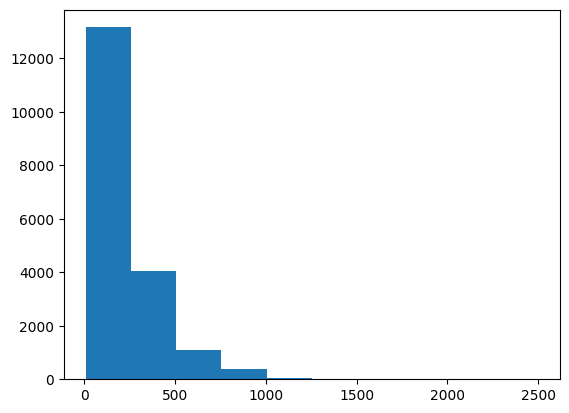

In [ ]:
import matplotlib.pyplot as plt

plt.hist(len)

이렇게 각각 길이가 다른 시퀀스 데이터를 분석하기는 곤란하다. tensorflow가 제공하는 `pad_sequences()`를 이용해서 모든 데이터의 길이를 같게 만들어보자(여기서는 길이 100을 적용).

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq=pad_sequences(train,maxlen=100)

In [ ]:
train_seq.shape

(18750, 100)

In [ ]:
type(train)

numpy.ndarray

In [ ]:
type(train_seq)

numpy.ndarray

* `pad_sequences()` : 정수값들이 들어있는 길이가 다른 리스트들을 입력받아 일정한 길이(`maxlen`으로 지정)의 넘파이 배열로 만든다. `tf.keras.utils.pad_sequences()`와 같이 이용할 수 있고 `tf.keras.preprocessing.sequence.pad_sequences()`와 같이 해도 된다. 입력할 수 있는 매개변수들은 아래와 같다.

      tensorflow.keras.utils.pad_sequences(
      sequences,
      maxlen=None,
      dtype='int32',
      padding='pre',
      truncating='pre',
      value=0.0)
  

간단한 리스트로 연습해보자.

In [ ]:
sequence = [[1], [2, 3], [4, 5, 6]]

In [ ]:
pad_sequences(sequence)

array([[0, 0, 1],
       [0, 2, 3],
       [4, 5, 6]], dtype=int32)

In [ ]:
pad_sequences(sequence, maxlen = 2)

array([[0, 1],
       [2, 3],
       [5, 6]], dtype=int32)

In [ ]:
pad_sequences(sequence, value=-1, maxlen=2)

array([[-1,  1],
       [ 2,  3],
       [ 5,  6]], dtype=int32)

In [ ]:
pad_sequences(sequence, padding = 'post')

array([[1, 0, 0],
       [2, 3, 0],
       [4, 5, 6]], dtype=int32)

In [ ]:
pad_sequences(sequence, truncating = 'post', maxlen = 2)

array([[0, 1],
       [2, 3],
       [4, 5]], dtype=int32)

이제 입력으로 이용할 시퀀스 데이터 세트가 길이 100, 샘플 수 2만인 2차원 배열이 되었다. 각 샘플은 단어 100개로 이루어진 시퀀스이며 시퀀스의 각 단어는 1차원 배열로 RNN 순환층 셀에 입력된다. 만일 어휘사전이 500개로 이루어져 있다면 순환층은 (100, 500) 크기의 2차원 배열을 입력으로 받아들인다.

원래 길이가 제각각이던 리뷰 데이터들(`train_input`)이 어떻게 바뀌었는지 알아보자.

In [ ]:
len(train[0])

121

In [ ]:
len(train_seq[0])

100

즉 길이가 259이던 첫번째 항목의 길이가 100으로 줄었다. 어떤 부분이 사라지고 어떤 부분이 남았을까? 출력을 비교해보면 원본의 뒷부분이 남은 것을 알 수 있다.`padding = 'pre', truncating = 'pre'` 가 기본값인데, 보통 글에서 중요한 내용이 앞부분보다 뒷부분에 더 많기 때문이다.

이번에는 5번 항목(여섯번째 항목)을 살펴보자.

In [ ]:
len(train[5])

241

원본 시퀀스의 길이가 241으로 100보다 크다. 이럴 때 새로 만든 길이 100인 `train_seq`에는 맨뒤에서 100번째 앞자리까지에 갚이 들어갔을 것 이다.

In [ ]:
train[5][-10:]

[47, 101, 155, 33, 32, 8, 81, 19, 14, 22]

In [ ]:
print(train_seq[5])

[  2   2   8   2   5  50  16   4   2   2 255  37 426   2   2  42   2  13
 482  59  69  43   2 112   2 322   4   2  34   2   2 168  40 164  53  74
   2  39   2   2   5 164 495  13   2  50   2  33  89 142  38   2   5   2
 100  30   2   8 164  48  25 371 119  14 123   5  12   9   2 145   8   2
  11   2  67  12  21  92 104  15   4 196   2   2   2  15  16   6   2 347
  47 101 155  33  32   8  81  19  14  22]


validation 데이터도 역시 길이 100인 시퀀스로 바꿔주자.

In [ ]:
val_seq = pad_sequences(val, maxlen=100)

In [ ]:
val_seq.shape

(6250, 100)

### 2) 순환 신경망 만들기

케라스가 제공하는 순환신경망 가운데 가장 간단한 것은 `SimpleRNN`이다. 신경망을 만드는 절차는 밀집층(7장에서 공부)을 만들 때와 흡사하다. 즉 `model = keras.Sequential()`로 시작하여 model에 층을 하나씩 추가해가면 된다. 달라지는 것은 `Dense` 대신 `SimpleRNN`이 들어가는 것뿐이다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.datasets import imdb

(train,target1),(test,target2)=imdb.load_data(num_words=500)

In [ ]:
from sklearn.model_selection import train_test_split

train,val,target1,target3=train_test_split(train,target1,test_size=0.2,random_state=0)

In [ ]:
from tensorflow import keras

m=keras.Sequential()

m.add(keras.layers.SimpleRNN(8,input_shape=(100,500)))
m.add(keras.layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


위의 모델은 순환층이 하나인 신경망인데 `SimpleRNN(8, input_shape=(100, 500))`에서 8은 순환신경망 뉴런의 수다. 그리고 기본 활성화함수는 tanh 함수다. 그런데 `input_shape`이 왜 (100, 500)일까?

앞에 있는 100은 시퀀스의 길이(타임스텝의 길이)다. 2차원 배열 `input_seq`에 항목으로 들어있는 각 시퀀스는 0부터 499 사이의 정수값 100개로 이루어지며, 각 정수값은 텍스트의 단어를 나타낸다. 그런데 이 정수값을 받아들인 다음 신경망의 활성화함수는 큰 값은 큰 출력으로 만들고 작은 값은 작은 출력으로 만든다. 단어들 사이에는 아무런 순서나 크기가 없는데도 숫자로 바꾼 결과 이런 문제가 생기는 것이다.(교재 501쪽 `He follows the cat. He loves the cat.`이라는 보기 문장과 이어지는 설명을 보라).

그와 같은 문제를 피할 수 있는 방법이 둘 있다. 하나는 one-hot encoding을 이용하는 것이다. 시퀀스 길이가 100이고 단어(정수값)가 500개이므로 one-hot encoding행렬은 $100 \times 500$ 행렬이 된다. 바로 이 행렬의 크기를 `input_shape = (100, 500)`에 적어준다.

one-hot encoding 행렬은 아래와 같이 간단히 만들 수 있다.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq=pad_sequences(train,maxlen=100)

In [ ]:
train_oh=keras.utils.to_categorical(train_seq)

데이터의 차원과 크기가 어떻게 달라졌는지 확인해보자.

In [ ]:
train_seq.shape

(20000, 100)

In [ ]:
train_oh.shape

(20000, 100, 500)

`train_seq`의 첫번째 샘플의 앞부분 토큰 값들을 출력해보자.

In [ ]:
len(train_seq[0])

100

In [ ]:
len(train_oh[0])

100

In [ ]:
train_seq[0].shape

(100,)

In [ ]:
train_oh[0].shape

(100, 500)

In [ ]:
train_seq[0][:5]

array([468,  40,  59,  16,   2], dtype=int32)

5번쨰 토큰값 2가 one-hot encoding 행렬에서는 어떻게 나타날까?

In [ ]:
train_oh[0][4][:10]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

3번째 값만 1이고 나머지는 모두 0으로 encoding된 것을 알 수 있다.

In [ ]:
import numpy as np

np.sum(train_oh[0][4])

1.0

`val_seq`데이터도 마찬가지로 바꾸자.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

val_seq=pad_sequences(val,maxlen=100)

In [ ]:
val_oh = keras.utils.to_categorical(val_seq)

모델의 구조는 아래와 같다.

In [ ]:
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │           4,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,081 (15.94 KB)

 Trainable params: 4,081 (15.94 KB)

 Non-trainable params: 0 (0.00 B)

이제 `SimpleRNN` 층의 parameter수가 4072개인 이유를 알아보자. 이 층에는 뉴런이 8개다. 입력 데이터가 $ 100 \times 500$이므로 시퀀스 데이터 하나는 500개 특성으로 이루어져 있다. 500개 특성 각각이 8개의 뉴런 모두와 완전연결되어야하므로 $ 500 \times 8 = 4000$개 가중치가 필요하다. 그런데 순환신경망에서는 각 뉴런의 출력을 8개 각 뉴런에 전달해야하므로 $8 \times 8 = 64$개 가중치가 또 필요하다. 그리고 각 뉴런마다 절편이 하나씩 모두 8개 필요하다. 전체 가중치의 수는 $ 4000 + 64 + 8 = 4072$개다.

* 심층 RNN

In [ ]:
model2 = keras.Sequential()

model2.add(keras.layers.SimpleRNN(8, return_sequences = True,  input_shape=(100, 500)))
model2.add(keras.layers.SimpleRNN(16))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


* 퀴즈 : 첫번째 층에서 `return_sequences = True`가 없다면 어떻게 되겠는가? 오류 발생

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 100, 8)              │           4,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 16)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,489 (17.54 KB)

 Trainable params: 4,489 (17.54 KB)

 Non-trainable params: 0 (0.00 B)

* 퀴즈 : 두번째 SimpleRNN층의 parameter 수가 400인 이유를 설명해보시오.

In [ ]:
8*16+16**2+16

400

### 3) 순환 신경망 훈련하기

이제 데이터를 이용해서 모델을 훈련할 준비가 다 되었다.

In [ ]:
bm = '/content/drive/MyDrive/bm_RNN.keras'

In [ ]:
m.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

cb1 = keras.callbacks.ModelCheckpoint(bm,save_best_only=True)
cb2 = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = m.fit(train_oh, target1, epochs=20,
                validation_data=(val_oh, target3),
                callbacks=[cb1, cb2])

* 퀴즈 : 위에서 `loss='binary_crossentropy'`를 선택한 이유는? 이진분류

아래 `model.fit()` 과정은 실행 시간이 상당히 길다.(실행하지 말고 교재의 결과를 볼 것). 이 모델대신 아래에서 공부할 embedding을 이용한 모델을 만들어 실행해보자.

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0, 10, 1))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(range(0, 10, 1))
plt.legend(['train_loss', 'val_loss','train_acc','val_acc'])

그림 설명은 교재 514쪽 참조.

### 4) 단어 임베딩을 사용하기

* one hot encoding의 문제점 :

    - <u>입력 데이터가 엄청나게 커진다.</u> 이유는? 단어 하나가 어휘사전 크기만큼의 차원을 갖기 때문. 타임스텝이 100이고 어휘사전 크기가 5,000이라면 100개의 입력 단어가 100 x 5,000 = 500,000개의 입력으로 늘어난다.

    - <u> 단어의 의미나 단어들끼리의 위치 등을 나타낼 수 없다.</u>

    우리가 사용하는 단어들 사이에는 가깝고 먼 관계들이 있다. 가령 '대학교'와 '학생'은 서로 가까운 관계이지만 이 단어들과 '전쟁', '바다'같은 단어는 서로 별 관계가 없다. one-hot encoding 방법은 단어들 사이의 관계를 전혀 나타내지 못하는 단점이 있다. 단어 임베딩(word embedding)은 단어마다 고정된 크기의 실수 벡터로 바꾸어주는데 가까운 단어들은 비슷한 숫자들로 임베딩하므로 단어들 사이의 관계를 나타낼 수 있다.

  아래 코드에서 `keras.layers.Embedding(500, 16, input_length=100)`을 잘 보자.
  
  500은 어휘 사전의 크기이고 16은 **임베딩 벡터의 길이**다. 그리고 `input_length = 100`은 입력 시퀀스의 길이다.

In [1]:
from tensorflow.keras.datasets import imdb

(train,target1),(test,target2)=imdb.load_data(num_words=500)

from sklearn.model_selection import train_test_split

train,val,target1,target3=train_test_split(train,target1,test_size=0.2,random_state=0)

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq=pad_sequences(train,maxlen=100)

val_seq=pad_sequences(val,maxlen=100)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
from tensorflow import keras

m = keras.Sequential()

m.add(keras.layers.Embedding(500, 16, input_length=100, input_shape=(100,)))
m.add(keras.layers.SimpleRNN(8))
m.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,209 (32.07 KB)

 Trainable params: 8,209 (32.07 KB)

 Non-trainable params: 0 (0.00 B)

위의 결과를 보고 parameter 수를 설명해보자. 먼저 embedding 층은 500개 단어를 길이 16인 벡터로 바꾸므로 총 $500 \times 16 = 8000$개의 파라미터가 필요하다. 또 SimpleRNN층은 길이 16인 벡터와 뉴런 8개를 연결하므로 $16 \times 8 = 128$개의 파라미터가 필요하다. 그리고 8개의 뉴런끼리 연결하는 64개의 파라미터가 필요하고 뉴런마다 절편이 하나씩 있으므로 8개의 파라미터가 필요하다. 즉 128+64+8=200개다. one-hot encoding 방법과 비교했을 때 embedding으로 인해 순환신경망의 파라미터 수가 크게 줄어든 것을 알 수 있다.

위의 그림에서 확인할 수 있듯이 어휘사전이 500개로 이루어졌다고 할 때 one hot encoding을 이용하면 100개의 타임스텝 입력이 100 x 500 = 50,000개로 늘어나지만 embedding을 이용하면 그보다 훨씬 적은 100 x 16 = 1,600개가 된다.

우리가 가진 `train_seq`는 (20,000, 100) 크기의 2차원 배열인데 앞에서 one hot encoding 행렬로 바꾼 `train_oh`는 (20,000, 100, 500) 크기가 되었다. 하지만 embedding을 이용하면 `train_seq`를 그보다 훨씬 작은 크기인 (20,000, 100, 16)로 만들어 순환층에 입력할 수 있다.

In [6]:
m.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

cb1 = keras.callbacks.ModelCheckpoint('RNN_EMB_BM.keras',save_best_only=True)
cb2 = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = m.fit(train_seq, target1, epochs=20, batch_size=32,
                validation_data=(val_seq, target3),
                callbacks=[cb1, cb2])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5958 - loss: 0.6661 - val_accuracy: 0.7128 - val_loss: 0.5773
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7309 - loss: 0.5592 - val_accuracy: 0.7140 - val_loss: 0.5784
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7412 - loss: 0.5370 - val_accuracy: 0.7490 - val_loss: 0.5143
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7758 - loss: 0.4774 - val_accuracy: 0.7692 - val_loss: 0.4930
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.7892 - loss: 0.4631 - val_accuracy: 0.7682 - val_loss: 0.4934
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.7949 - loss: 0.4397 - val_accuracy: 0.7746 - val_loss: 0.4745
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8053 - loss: 0.4299 - val_accuracy: 0.7504 - val_loss: 0.5059
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8034 - loss: 0.4353 - 

* 퀴즈 : 출력에 나오는 313이라는 숫자의 의미는?

train data, validation data에서의 손실을 그림으로 그려서 비교해보자.

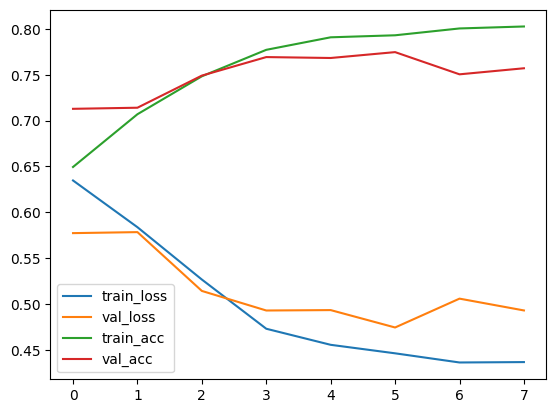

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0, 8, 1))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(range(0, 8, 1))
plt.legend(['train_loss', 'val_loss','train_acc','val_acc'])
plt.show()

최적모델로 valdidation data 중 첫번째 target을 예측해보자.

In [13]:
m.predict(val_seq[0])

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=int32)
  • training=False
  • mask=None

* 퀴즈 : 오류가 생기는 이유를 설명하고 고친 다음, 결과를 설명해보라.

In [14]:
m.predict(val_seq[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[0.87113976]], dtype=float32)

이번에는 valdidation data 중 앞에 있는 30개를 예측해보자.

In [33]:
pred = m.predict(val_seq[0:10])
pred=pred.reshape(-1)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


array([0.8711397 , 0.7708926 , 0.2943153 , 0.0307087 , 0.07036055,
       0.94740945, 0.90505904, 0.95387673, 0.8541775 , 0.256261  ],
      dtype=float32)

In [34]:
pred.shape

(10,)

In [35]:
pred >= 0.5

array([ True,  True, False, False, False,  True,  True,  True,  True,
       False])

In [36]:
(pred >= 0.5) == target3[:10]

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True])

In [20]:
m.evaluate(val_seq, target3)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7792 - loss: 0.4724


[0.4744698703289032, 0.7746000289916992]